In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from keras import optimizers
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, TimeDistributed, Input, Activation, concatenate
from keras.callbacks import History
from keras.models import Model

# The values have around 15 decimals, so for more clarity in reading we're increasing the number of displayed values
pd.set_option('display.float_format', '{:.15f}'.format)

# 1. Importing the sensor and location data

## Full sensor data and location

In [40]:
full_sensor_and_loc_file = '../data/Processed/full_sensor_data_and_location.csv'

In [41]:
df_full_sensor_and_loc = pd.read_csv(full_sensor_and_loc_file, index_col=0)
df_full_sensor_and_loc

,ax,ay,az,gx,gy,gz,mx,my,mz,a_total,g_total,m_total,lat,long
11:05:09:00,0.917251600000000,0.223266600000000,9.617767000000001,-0.033401490000000,0.057952880000000,0.003723144500000,51.450348499999997,-49.124908499999997,-263.400264999999990,9.663986782827630,0.066992967089706,272.838632163932175,44.434918000000003,26.047605999999998
11:05:09:01,0.799926760000000,0.194534300000000,9.680023000000000,-0.052566530000000,0.046249390000000,-0.004806518600000,52.200316999999998,-48.599243000000001,-263.549800000000005,9.714966376461094,0.070180829096450,273.029772360293236,44.434918000000003,26.047606078717038
11:05:09:02,0.658676150000000,0.101165770000000,9.876343000000000,-0.057891846000000,0.024932861000000,-0.003738403300000,52.349853500000002,-49.124908499999997,-263.175200000000018,9.898799919043093,0.063143400685792,272.791737487752755,44.434918000000003,26.047606157434078
11:05:09:03,0.594024660000000,0.072433470000000,10.029572000000000,-0.036590576000000,0.002563476600000,0.007980347000000,52.499389999999998,-49.650573999999999,-262.800599999999974,10.047408939992856,0.037538348425722,272.553702615212273,44.434917999999989,26.047606236151118
11:05:09:04,0.634735100000000,0.041305542000000,10.098998999999999,-0.012084961000000,-0.029388428000000,0.015441894500000,50.999450000000003,-50.025176999999999,-262.274935000000028,10.119010603659476,0.035329563943415,271.834052942028165,44.434917999999989,26.047606314868165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19:09:27:16,1.302719100000000,0.520156860000000,7.142166000000000,-0.118621826000000,-0.505569460000000,0.092132570000000,22.650145999999999,-15.150451500000001,-262.875364999999988,7.278610814164050,0.527408785424618,264.286459212824525,44.434937499964583,26.047601919741037
19:09:27:17,2.049713100000000,0.280731200000000,8.202788999999999,-0.301849370000000,-0.332992550000000,0.140075680000000,23.100280000000001,-16.200256000000000,-262.800599999999974,8.459662001373697,0.470763503951147,264.310852200404213,44.434937499964576,26.047601814784940
19:09:27:18,2.140686000000000,0.043701172000000,9.170044000000001,-0.590530400000000,0.304031370000000,0.046325684000000,23.100280000000001,-13.949585000000001,-261.749270000000024,9.416695455676912,0.665813259304968,263.136645496752351,44.434937499964576,26.047601709828850
19:09:27:19,1.896484400000000,-0.226837160000000,9.799728000000000,-0.686401370000000,0.651306150000000,-0.067657470000000,24.050394333333333,-13.749694999999999,-262.549340000000029,9.984126253738191,0.948643281224560,264.009983987171552,44.434937499964569,26.047601604872760


## 1.1. Full sensor data, no downsampling (so each 10ms)

In [83]:
full_data_no_downsample = df_sensor_and_loc.copy(deep=True)
# full_data_no_downsample.reset_index(inplace=True)
# full_data_no_downsample.drop(['index'], axis=1, inplace=True)
full_data_no_downsample.head()

,ax,ay,az,gx,gy,gz,mx,my,mz,a_total,g_total,m_total,lat,long
11:05:09:00,0.917251600000000,0.223266600000000,9.617767000000001,-0.033401490000000,0.057952880000000,0.003723144500000,51.450348499999997,-49.124908499999997,-263.400264999999990,9.663986782827630,0.066992967089706,272.838632163932175,44.434918000000003,26.047605999999998
11:05:09:01,0.799926760000000,0.194534300000000,9.680023000000000,-0.052566530000000,0.046249390000000,-0.004806518600000,52.200316999999998,-48.599243000000001,-263.549800000000005,9.714966376461094,0.070180829096450,273.029772360293236,44.434918000000003,26.047606078717038
11:05:09:02,0.658676150000000,0.101165770000000,9.876343000000000,-0.057891846000000,0.024932861000000,-0.003738403300000,52.349853500000002,-49.124908499999997,-263.175200000000018,9.898799919043093,0.063143400685792,272.791737487752755,44.434918000000003,26.047606157434078
11:05:09:03,0.594024660000000,0.072433470000000,10.029572000000000,-0.036590576000000,0.002563476600000,0.007980347000000,52.499389999999998,-49.650573999999999,-262.800599999999974,10.047408939992856,0.037538348425722,272.553702615212273,44.434917999999989,26.047606236151118
11:05:09:04,0.634735100000000,0.041305542000000,10.098998999999999,-0.012084961000000,-0.029388428000000,0.015441894500000,50.999450000000003,-50.025176999999999,-262.274935000000028,10.119010603659476,0.035329563943415,271.834052942028165,44.434917999999989,26.047606314868165


In [84]:
# fig = px.scatter_geo(full_data_no_downsample,lat=full_data_no_downsample['lat'],lon=full_data_no_downsample['long'], hover_name=full_data_no_downsample.index)
# fig.update_layout(title = 'World map', title_x=0.5, geo = dict(projection_scale=800000, center=dict(lat=full_data_no_downsample['lat'][0], lon=full_data_no_downsample['long'][0])))
# fig.show()

In [85]:
full_data_no_downsample['a_total'][:1000]

11:05:09:00    9.663986782827630
11:05:09:01    9.714966376461094
11:05:09:02    9.898799919043093
11:05:09:03   10.047408939992856
11:05:09:04   10.119010603659476
                     ...        
11:05:18:95    9.014608908572036
11:05:18:96    8.773951386186262
11:05:18:97    8.593369936547457
11:05:18:98    8.545187432425262
11:05:18:99    8.519133994949202
Name: a_total, Length: 1000, dtype: float64

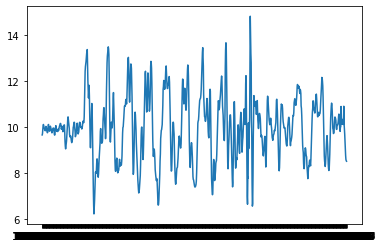

In [101]:
# [:1000] = first 1000 values, so 10 sec (10ms intervals * 1000 values)
plt.plot(full_data_no_downsample['a_total'][:1000])

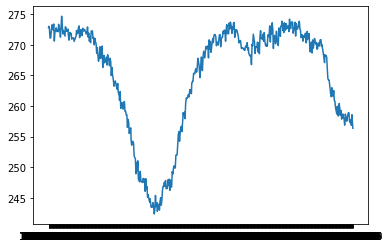

In [102]:
plt.plot(full_data_no_downsample['m_total'][:1000])

In [93]:
full_data_no_downsample['a_total'][:100]

11:05:09:00    9.663986782827630
11:05:09:01    9.714966376461094
11:05:09:02    9.898799919043093
11:05:09:03   10.047408939992856
11:05:09:04   10.119010603659476
                     ...        
11:05:09:95    9.483281208402502
11:05:09:96    9.390579060259046
11:05:09:97    9.327960061715832
11:05:09:98    9.384314969691712
11:05:09:99    9.440669877667588
Name: a_total, Length: 100, dtype: float64

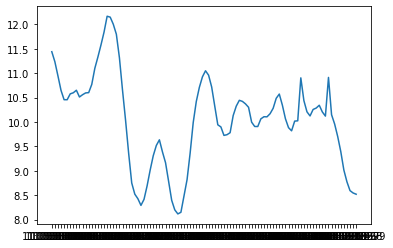

In [97]:
# [:100] = first 100 values, so 1 sec (10ms intervals * 100 values)
plt.plot(full_data_no_downsample['a_total'][900:1000])

## 1.2. Full sensor data, downsampled by 10 (so each 100ms)

In [88]:
full_data_downsample_10 = df_sensor_and_loc.copy(deep=True)[::10]
full_data_downsample_10.head()

,ax,ay,az,gx,gy,gz,mx,my,mz,a_total,g_total,m_total,lat,long
11:05:09:00,0.917251600000000,0.223266600000000,9.617767000000001,-0.033401490000000,0.057952880000000,0.003723144500000,51.450348499999997,-49.124908499999997,-263.400264999999990,9.663986782827630,0.066992967089706,272.838632163932175,44.434918000000003,26.047605999999998
11:05:09:10,0.826263400000000,0.127502440000000,9.809296000000000,-0.027008057000000,0.016418457000000,0.011169434000000,51.899719000000005,-49.724578500000000,-263.099670000000003,9.844859374008424,0.033522486916344,272.741548127234410,44.434917999999961,26.047606787170416
11:05:09:20,0.905273440000000,0.247207640000000,10.063095000000001,-0.022750854000000,-0.048568726000000,-0.026107788000000,51.899719500000003,-49.725341999999998,-261.675259999999980,10.106755789939164,0.059650139121760,271.367338695894091,44.434917999999918,26.047607574340830
11:05:09:30,0.562912000000000,0.101165770000000,9.850006000000000,0.012405395500000,-0.046432495000000,-0.019714355000000,51.849873666666667,-50.150553333333335,-262.650553333333335,9.866596304339186,0.051947340860745,272.376289894453294,44.434917999999882,26.047608361511248
11:05:09:40,0.713745100000000,0.151443480000000,9.658462999999999,-0.009963989000000,-0.092239380000000,0.001586914100000,51.300049000000001,-48.974608500000002,-262.574770000000001,9.685983415109565,0.092789560813366,271.985441627272223,44.434917999999833,26.047609148681666


In [89]:
# fig = px.scatter_geo(full_data_downsample_10,lat=full_data_downsample_10['lat'],lon=full_data_downsample_10['long'], hover_name=full_data_downsample_10.index)
# fig.update_layout(title = 'World map', title_x=0.5, geo = dict(projection_scale=800000, center=dict(lat=full_data_downsample_10['lat'][0], lon=full_data_downsample_10['long'][0])))
# fig.show()

### Plot 10 sec

In [90]:
full_data_downsample_10['a_total'][:100]

11:05:09:00    9.663986782827630
11:05:09:10    9.844859374008424
11:05:09:20   10.106755789939164
11:05:09:30    9.866596304339186
11:05:09:40    9.685983415109565
                     ...        
11:05:18:50   11.049043723777812
11:05:18:60   10.324244091724973
11:05:18:70   10.105134920776774
11:05:18:80   10.023585475657224
11:05:18:90   10.912412224992751
Name: a_total, Length: 100, dtype: float64

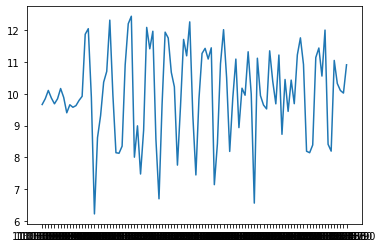

In [91]:
# [:100] = first 100 values, so 10 sec (100ms intervals * 100 values)
plt.plot(full_data_downsample_10['a_total'][:100])

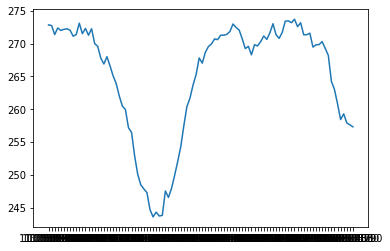

In [103]:
plt.plot(full_data_downsample_10['m_total'][:100])

### Plot for 1 sec

In [98]:
full_data_downsample_10['a_total'][:10]

11:05:18:00   11.439533842186588
11:05:18:10   10.557910167612071
11:05:18:20   12.002812507011091
11:05:18:30    8.414656088386627
11:05:18:40    8.199172290844604
11:05:18:50   11.049043723777812
11:05:18:60   10.324244091724973
11:05:18:70   10.105134920776774
11:05:18:80   10.023585475657224
11:05:18:90   10.912412224992751
Name: a_total, dtype: float64

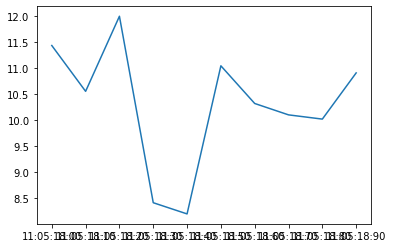

In [99]:
# [:10] = first 10 values, so 1 sec (100ms intervals * 10 values)
plt.plot(full_data_downsample_10['a_total'][90:100])

## 1.3. Full sensor data, downsampled by 50 (so each 500ms)

In [74]:
full_data_downsample_50 = df_sensor_and_loc.copy(deep=True)[::50]
full_data_downsample_50.head()

,ax,ay,az,gx,gy,gz,mx,my,mz,a_total,g_total,m_total,lat,long
11:05:09:00,0.917251600000000,0.223266600000000,9.617767000000001,-0.033401490000000,0.057952880000000,0.003723144500000,51.450348499999997,-49.124908499999997,-263.400264999999990,9.663986782827630,0.066992967089706,272.838632163932175,44.434918000000003,26.047605999999998
11:05:09:50,0.632339500000000,0.077224730000000,9.823669000000001,-0.016357422000000,-0.090118410000000,-0.002670288000000,51.824950999999999,-49.800109999999997,-262.500000000000000,9.844302388881848,0.091629817818312,272.162018343783700,44.434917999999783,26.047609935852080
11:05:10:00,0.718536400000000,0.630279540000000,9.529175000000000,-0.252838130000000,-0.019805908000000,-0.194427490000000,53.849792000000001,-47.999572999999998,-263.400269999999978,9.576989247007257,0.319564458038283,273.099727833439033,44.434917999999570,26.047613871704161
11:05:10:50,0.766418460000000,0.364532470000000,12.016754000000001,0.914688100000000,-0.188110350000000,0.071899414000000,57.150269999999999,-47.850037000000000,-259.500119999999981,12.046686593168641,0.936594549307370,269.992762277044505,44.434917999999350,26.047617807556239
11:05:11:00,1.475097700000000,0.795486450000000,10.228287000000000,-0.375350950000000,-0.174270630000000,-0.034637450000000,56.849670000000003,-47.700499999999998,-256.050099999999986,10.364678811764882,0.415281038682242,266.587464801646092,44.434917999999030,26.047623632617320


In [75]:
# fig = px.scatter_geo(full_data_downsample_50,lat=full_data_downsample_50['lat'],lon=full_data_downsample_50['long'], hover_name=full_data_downsample_50.index)
# fig.update_layout(title = 'World map', title_x=0.5, geo = dict(projection_scale=800000, center=dict(lat=full_data_downsample_50['lat'][0], lon=full_data_downsample_50['long'][0])))
# fig.show()

### Plot 10 sec

In [76]:
full_data_downsample_50['a_total'][:20]

11:05:09:00    9.663986782827630
11:05:09:50    9.844302388881848
11:05:10:00    9.576989247007257
11:05:10:50   12.046686593168641
11:05:11:00   10.364678811764882
11:05:11:50    8.132844504773423
11:05:12:00    8.008924150278327
11:05:12:50   11.415285914004770
11:05:13:00   11.937892069839142
11:05:13:50    9.615699966550720
11:05:14:00    7.450883493371057
11:05:14:50   11.445280502483371
11:05:15:00   10.500801043444881
11:05:15:50   10.176348318761811
11:05:16:00   11.119017010602676
11:05:16:50   10.393170361853514
11:05:17:00    9.448729162617306
11:05:17:50   10.923125522177129
11:05:18:00   11.439533842186588
11:05:18:50   11.049043723777812
Name: a_total, dtype: float64

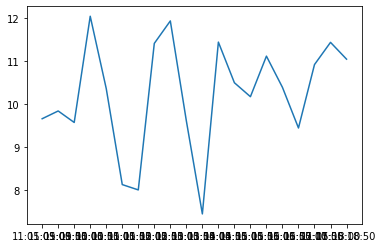

In [77]:
# [:20] = first 20 values, so 10 sec (500ms intervals * 20 values)
plt.plot(full_data_downsample_50['a_total'][:20])

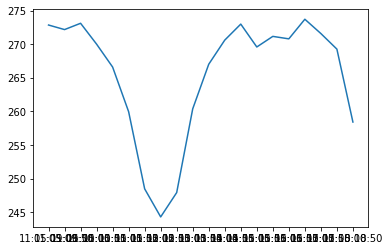

In [104]:
plt.plot(full_data_downsample_50['m_total'][:20])

### Plot 1 sec

In [95]:
full_data_downsample_50['a_total'][:2]

11:05:09:00   9.663986782827630
11:05:09:50   9.844302388881848
Name: a_total, dtype: float64

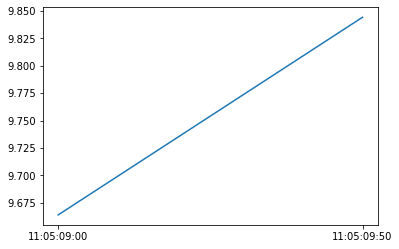

In [96]:
plt.plot(full_data_downsample_50['a_total'][:2])

## 1.4. Full sensor data, downsampled by 100 (so each 1000ms)

In [49]:
full_data_downsample_100 = df_sensor_and_loc.copy(deep=True)[::100]
full_data_downsample_100.head()

,ax,ay,az,gx,gy,gz,mx,my,mz,a_total,g_total,m_total,lat,long
11:05:09:00,0.917251600000000,0.223266600000000,9.617767000000001,-0.033401490000000,0.057952880000000,0.003723144500000,51.450348499999997,-49.124908499999997,-263.400264999999990,9.663986782827630,0.066992967089706,272.838632163932175,44.434918000000003,26.047605999999998
11:05:10:00,0.718536400000000,0.630279540000000,9.529175000000000,-0.252838130000000,-0.019805908000000,-0.194427490000000,53.849792000000001,-47.999572999999998,-263.400269999999978,9.576989247007257,0.319564458038283,273.099727833439033,44.434917999999570,26.047613871704161
11:05:11:00,1.475097700000000,0.795486450000000,10.228287000000000,-0.375350950000000,-0.174270630000000,-0.034637450000000,56.849670000000003,-47.700499999999998,-256.050099999999986,10.364678811764882,0.415281038682242,266.587464801646092,44.434917999999030,26.047623632617320
11:05:12:00,1.403274500000000,-0.894821170000000,7.834091000000000,0.079528810000000,0.103759766000000,0.291336060000000,53.549956999999999,-30.750274000000001,-240.674595000000011,8.008924150278327,0.319323692382376,248.472678615840010,44.434917999998270,26.047637486816647
11:05:13:00,0.076889040000000,1.262359600000000,11.870711999999999,0.044372560000000,0.038787840000000,0.319030760000000,30.900573999999999,-11.849976000000000,-245.700070000000011,11.937892069839142,0.324428800261316,247.918921832793870,44.434917999997403,26.047653230224970


In [50]:
# fig = px.scatter_geo(full_data_downsample_100,lat=full_data_downsample_100['lat'],lon=full_data_downsample_100['long'], hover_name=full_data_downsample_100.index)
# fig.update_layout(title = 'World map', title_x=0.5, geo = dict(projection_scale=800000, center=dict(lat=full_data_downsample_100['lat'][0], lon=full_data_downsample_100['long'][0])))
# fig.show()

In [79]:
full_data_downsample_100['a_total'][:10]

11:05:09:00    9.663986782827630
11:05:10:00    9.576989247007257
11:05:11:00   10.364678811764882
11:05:12:00    8.008924150278327
11:05:13:00   11.937892069839142
11:05:14:00    7.450883493371057
11:05:15:00   10.500801043444881
11:05:16:00   11.119017010602676
11:05:17:00    9.448729162617306
11:05:18:00   11.439533842186588
Name: a_total, dtype: float64

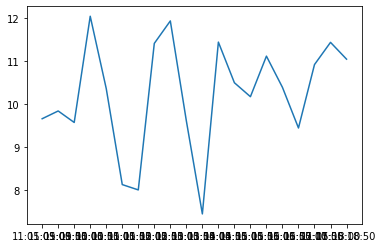

In [80]:
# [:10] = first 10 values, so 10 sec (1000ms intervals * 10 values)
plt.plot(full_data_downsample_50['a_total'][:20])

## 1.5. Full sensor data, downsampled by 200 (so each 2000ms)

In [51]:
full_data_downsample_200 = df_sensor_and_loc.copy(deep=True)[::200]
full_data_downsample_200.head()

,ax,ay,az,gx,gy,gz,mx,my,mz,a_total,g_total,m_total,lat,long
11:05:09:00,0.917251600000000,0.223266600000000,9.617767000000001,-0.033401490000000,0.057952880000000,0.003723144500000,51.450348499999997,-49.124908499999997,-263.400264999999990,9.663986782827630,0.066992967089706,272.838632163932175,44.434918000000003,26.047605999999998
11:05:11:00,1.475097700000000,0.795486450000000,10.228287000000000,-0.375350950000000,-0.174270630000000,-0.034637450000000,56.849670000000003,-47.700499999999998,-256.050099999999986,10.364678811764882,0.415281038682242,266.587464801646092,44.434917999999030,26.047623632617320
11:05:13:00,0.076889040000000,1.262359600000000,11.870711999999999,0.044372560000000,0.038787840000000,0.319030760000000,30.900573999999999,-11.849976000000000,-245.700070000000011,11.937892069839142,0.324428800261316,247.918921832793870,44.434917999997403,26.047653230224970
11:05:15:00,1.139907800000000,-0.212478640000000,10.436584000000000,-0.526611300000000,-0.224334720000000,-1.338516200000000,19.500731999999999,-42.449950000000001,-268.949900000000014,10.500801043444881,1.455771666693513,272.976785667844524,44.434917999996337,26.047672307531528
11:05:17:00,-0.040435790000000,-0.684127800000000,9.423843000000000,0.134918210000000,-0.216873170000000,0.421295170000000,17.700195000000001,-34.799956999999999,-270.899965000000009,9.448729162617306,0.492672828072324,273.699657822658537,44.434917999995939,26.047679716194267


In [52]:
# fig = px.scatter_geo(full_data_downsample_200,lat=full_data_downsample_200['lat'],lon=full_data_downsample_200['long'], hover_name=full_data_downsample_200.index)
# fig.update_layout(title = 'World map', title_x=0.5, geo = dict(projection_scale=800000, center=dict(lat=full_data_downsample_200['lat'][0], lon=full_data_downsample_200['long'][0])))
# fig.show()

# 2. Importing the ground truth data

In [53]:
position_file = '../data/Processed/partial_4_ground_truth.csv'
position_df = pd.read_csv(position_file, index_col=0)
position_df

,lat,long
11:05:09:00,44.434918000000003,26.047605999999998
11:05:10:60,44.434917999999307,26.047618594726657
11:05:11:60,44.434917999998618,26.047631189453320
11:05:12:40,44.434917999997921,26.047643784179972
11:05:13:20,44.434917999997225,26.047656378906638
...,...,...
13:04:50:40,44.434937499967326,26.047651878840107
13:04:51:20,44.434937499966637,26.047639284109248
13:04:52:20,44.434937499965947,26.047626689378390
13:04:53:20,44.434937499965251,26.047614094647528


In [54]:
# fig = px.scatter_geo(position_df,lat=position_df['lat'],lon=position_df['long'], hover_name=position_df.index)
# fig.update_layout(title = 'World map', title_x=0.5, geo = dict(projection_scale=800000, center=dict(lat=position_df['lat'][0], lon=position_df['long'][0])))
# fig.show()

In [105]:
data = {'c1': [1, 2, 3, 4], 'c2': [6, 10, 11, 22]}
df1 = pd.DataFrame(data)

In [106]:
sc = MinMaxScaler(feature_range=(0, 1))
data1_scaled = sc.fit_transform(df1)

In [107]:
data1_scaled

array([[0.        , 0.        ],
       [0.33333333, 0.25      ],
       [0.66666667, 0.3125    ],
       [1.        , 1.        ]])

In [108]:
data1_descaled = sc.inverse_transform(data1_scaled)

In [109]:
data1_descaled

array([[ 1.,  6.],
       [ 2., 10.],
       [ 3., 11.],
       [ 4., 22.]])